# Prediksi Kecepatan Angin Maksimum di Tanjungpinang Tahun 2022 dengan ARIMA

Notebook ini dibuat untuk proyek akhir Pembelajaran Mesin. Topik dari proyek ini adalah memprediksi kecepatan angin maksimum di Tanjungpinang tahun 2022 dengan model ARIMA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Fungsi Utilitas

In [ ]:
class ARIMA:
    def __init__(self, dataset, paramaters):
        self.dataset = dataset
        self.p, self.d, self.q = paramaters

        self.ar_coef = np.zeros(self.p)
        self.ma_coef = np.zeros(self.q)
    
    def predict(self, dataset):
        pass

    def fit(self, dataset):
        pass

In [12]:
def create_windowed_dataset(dataset, size):
    '''
    Membuat dataset yang terbagi berdasarkan ukuran jendela yang dibuat.
    Tiap item pada dataset yang terbagi berisi
    [a, b, c, ..., z] dengan:
    * a, b, c, ... sebagai data yang dilatih
    * z sebagai label

    Args:
        dataset (list/array): dataset yang akan dibuatkan jendelanya
        size (int): ukuran jendela
    
    Hasil:
        windowed_dataset (list/array)
    '''
    windowed_dataset = []

    for index in range(0, len(dataset)):
        window = dataset[index:index + size]
        
        if len(window) < size:
            break

        windowed_dataset.append(window)

    return windowed_dataset

## Pengertian ARIMA

## Membuka Dataset

In [9]:
# Buka dataset
df_kecepatan_angin = pd.read_csv('./kecepatan_angin_tpi_2022.csv',
                                 delimiter=';'
                                )
df_kecepatan_angin

,tanggal,kecepatan_maksimum
0,01/01/2022,4
1,02/01/2022,3
2,03/01/2022,3
3,04/01/2022,6
4,05/01/2022,7
...,...,...
361,28/12/2022,6
362,29/12/2022,8
363,30/12/2022,10
364,31/12/2022,13


In [10]:
# Konversi tipe data kolom tanggal menjadi tipe data datetime
df_kecepatan_angin['tanggal'] = pd.to_datetime(df_kecepatan_angin['tanggal'], dayfirst=True)

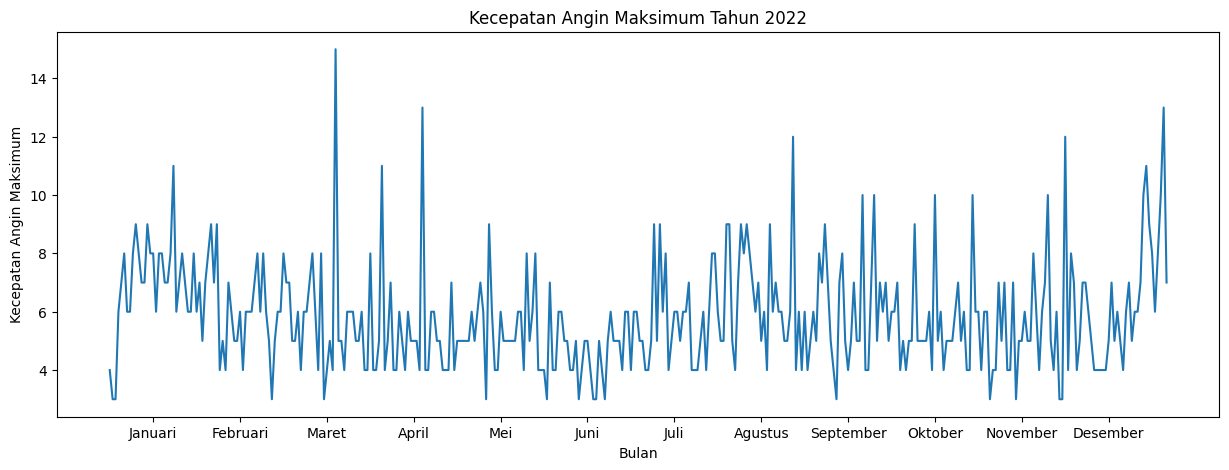

In [14]:
# Plot dataset
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(df_kecepatan_angin['kecepatan_maksimum'])
ax.set_xticks([15, 45, 75,
               105, 135, 165,
               195, 225, 255,
               285, 315, 345],
              labels=['Januari', 'Februari', 'Maret',
                      'April', 'Mei', 'Juni',
                      'Juli', 'Agustus', 'September',
                      'Oktober', 'November', 'Desember'])
ax.set_xlabel('Bulan')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Maksimum Tahun 2022')
plt.show()

## Menentukan Paramater untuk ARIMA

## Membagi Data

## Melatih Data

## Menvalidasi Data